In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Posterior Predictive Model Checking

### 1.1 Observed score distribution

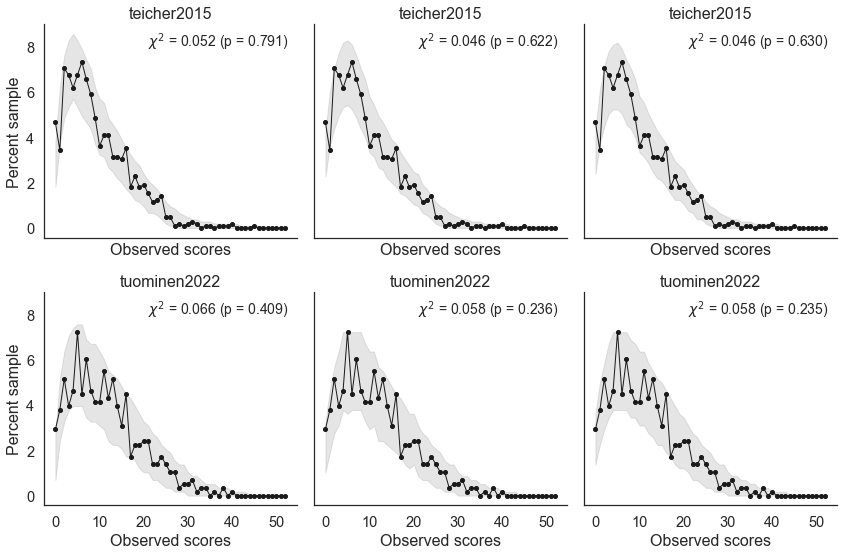

In [2]:
from arviz import hdi

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
nrow = len(studies)
ncol = len(models)
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4,nrow*4), sharex=True, sharey=True)

## Preallocate space.
ppmc1 = []

for j, m in enumerate(models):
    
    for i, study in enumerate(studies):

        ## Load posterior predictive check.
        df = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_ppmc1.csv'), index_col=0)

        ## Normalize counts across samples.
        df.loc[:,:] /= df.loc[0].values.sum()

        ## Extract values.
        NC  = df.values[0]
        NCr = df.values[1:]
        ENC = NCr.mean(axis=0)

        ## Compute 95% HDI.
        lb, ub = np.apply_along_axis(hdi, 0, NCr, hdi_prob=0.95)

        ## Compute chi-square statistics.
        xi = np.sum(np.divide(np.square(NC - ENC), ENC, where=ENC > 0))
        xr = np.divide(np.square(NCr - ENC), ENC, where=ENC > 0).sum(axis=1)

        ## Compute ppp-value.
        pppv = (xi >= xr).mean()

        ## Store statistics.
        ppmc1.append(dict(study=study, model=m, xi=xi, xr=xr.mean(), pval=pppv))
        
        ## Plot observed scores and 95% HDI.
        axes[i,j].plot(np.arange(NC.size), NC, 'o-', color='k', lw=1, markersize=4)    
        axes[i,j].fill_between(np.arange(NC.size), lb, ub, color='0.5', alpha=0.2)

        ## Add detail.
        axes[i,j].set(xticks=np.arange(0,51,10), xlabel='Observed scores', 
                      yticks=np.arange(0,0.09,0.02), yticklabels=np.arange(0,9,2),
                      ylabel='', title=study)
        if not j: axes[i,j].set_ylabel('Percent sample')

        ## Add annotations.
        axes[i,j].annotate(r'$\chi^2$ = %0.3f (p = %0.3f)' %(xi, pppv), (0,0), (0.97, 0.97), 
                           xycoords='axes fraction', ha='right', va='top', fontsize=14)
    
## Convert to DataFrame.
ppmc1 = DataFrame(ppmc1).sort_values(['study', 'model']).set_index(['study','model'])
ppmc1 = ppmc1.round(3)
    
sns.despine()
plt.tight_layout()

### 1.2 SGDDM

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
ppmc2 = []

for j, m in enumerate(models):
    
    for i, study in enumerate(studies):

        ## Load posterior predictive check.
        df = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_ppmc2.csv'), index_col=0)
        
        ## Extract statistics.
        sgddm, sgddmr, pppv = df.loc[0, ['obs', 'pred', 'pval']]
        
        ## Append.
        ppmc2.append(dict(study=study, model=m, sgddm=sgddm, sgddmr=sgddmr, pval=pppv))
        
## Convert to DataFrame.
ppmc2 = DataFrame(ppmc2).sort_values(['study', 'model']).set_index(['study','model'])
ppmc2 = ppmc2.round(3)

## Display DataFrame.
ppmc2

sgddm  sgddmr  pval
study        model                     
teicher2015  1      0.059   0.029   1.0
             2      0.045   0.029   1.0
             3      0.048   0.029   1.0
tuominen2022 1      0.065   0.037   1.0
             2      0.049   0.037   1.0
             3      0.053   0.037   1.0

### 1.3 SMBC

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3]

## Define threshold.
thresh = 0.99

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, study in enumerate(studies):

    for j, m in enumerate(models):
    
        ## Load posterior predictive check.
        df = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_ppmc2.csv')).tail(-1)
        n = len(df)
        
        ## 
        df = df.query(f'pval > {thresh}')
        k = len(df)
        
        print('%s %s: %s of %s (%0.3f)' %(study, m, k, n, (k/n)))

teicher2015 1: 80 of 780 (0.103)
teicher2015 2: 36 of 780 (0.046)
teicher2015 3: 50 of 780 (0.064)
tuominen2022 1: 69 of 780 (0.088)
tuominen2022 2: 30 of 780 (0.038)
tuominen2022 3: 38 of 780 (0.049)


## Section 2: Model Comparison

In [5]:
from itertools import combinations

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
ppmc0 = []

for study in studies:

    for m in models:
        
        ## Load data.
        df = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_ppmc0.csv'))
        
        ## Compute LOO-CV.
        loo = df.loo.sum()
        
        ## Append.
        ppmc0.append(dict(study=study, model=m, loo=loo))
        
## Convert to DataFrame.
ppmc0 = DataFrame(ppmc0).sort_values(['study', 'model']).set_index(['study','model']).round(1)

## Iteratively add comparison.
ppmc0['delta'] = '-'
for study in studies:
    
    ## Load winning model.
    x = read_csv(os.path.join('stan_results', study, f'grmq_m2_ppmc0.csv'))
    
    for m in [1,3]:
        
        ## Load alternate model.
        y = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_ppmc0.csv'))
        
        ## Compute delta-LOO.
        arr = x.loo - y.loo
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(len(x))
        
        ## Store.
        ppmc0.loc[(study,m),'delta'] = '%0.1f (%0.1f)' %(mu, se)
    
## Display DataFrame.
ppmc0

loo         delta
study        model                       
teicher2015  1     -15576.4  930.8 (38.7)
             2     -14645.5             -
             3     -14688.3   42.8 (29.7)
tuominen2022 1      -9956.8  567.2 (29.7)
             2      -9389.6             -
             3      -9402.4   12.8 (27.1)

## Section 3: Figures / Tables

### 3.1 Table 1

In [6]:
## Merge DataFrames.
table = ppmc1.merge(ppmc2, left_index=True, right_index=True)
table = table.merge(ppmc0, left_index=True, right_index=True)

## Display DataFrame.
table

xi     xr  pval_x  sgddm  sgddmr  pval_y      loo  \
study        model                                                         
teicher2015  1      0.052  0.046   0.791  0.059   0.029     1.0 -15576.4   
             2      0.046  0.046   0.622  0.045   0.029     1.0 -14645.5   
             3      0.046  0.046   0.630  0.048   0.029     1.0 -14688.3   
tuominen2022 1      0.066  0.079   0.409  0.065   0.037     1.0  -9956.8   
             2      0.058  0.078   0.236  0.049   0.037     1.0  -9389.6   
             3      0.058  0.079   0.236  0.053   0.037     1.0  -9402.4   

                           delta  
study        model                
teicher2015  1      930.8 (38.7)  
             2                 -  
             3       42.8 (29.7)  
tuominen2022 1      567.2 (29.7)  
             2                 -  
             3       12.8 (27.1)

In [7]:
## Convert to Latex.
print(table.to_latex())

\begin{tabular}{llrrrrrrrl}
\toprule
             &   &     xi &     xr &  pval\_x &  sgddm &  sgddmr &  pval\_y &      loo &         delta \\
study & model &        &        &         &        &         &         &          &               \\
\midrule
teicher2015 & 1 &  0.052 &  0.046 &   0.791 &  0.059 &   0.029 &     1.0 & -15576.4 &  930.8 (38.7) \\
             & 2 &  0.046 &  0.046 &   0.622 &  0.045 &   0.029 &     1.0 & -14645.5 &             - \\
             & 3 &  0.046 &  0.046 &   0.630 &  0.048 &   0.029 &     1.0 & -14688.3 &   42.8 (29.7) \\
tuominen2022 & 1 &  0.066 &  0.079 &   0.409 &  0.065 &   0.037 &     1.0 &  -9956.8 &  567.2 (29.7) \\
             & 2 &  0.058 &  0.078 &   0.236 &  0.049 &   0.037 &     1.0 &  -9389.6 &             - \\
             & 3 &  0.058 &  0.079 &   0.236 &  0.053 &   0.037 &     1.0 &  -9402.4 &   12.8 (27.1) \\
\bottomrule
\end{tabular}



### 3.2 Figure 1

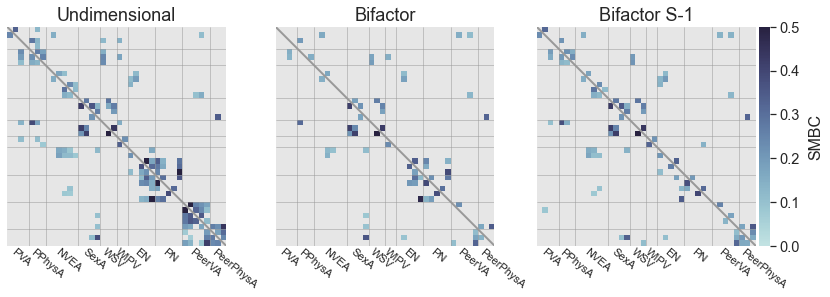

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3]

## Define threshold.
thresh = 0.99

## Define labels.
titles = ['Undimensional', 'Bifactor', 'Bifactor S-1']

## Define color palette.
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

## Define item order.
order = dict(
    PVA = [0, 1, 2, 3], 
    PPhysA = [5, 6, 7], 
    NVEA = [4, 27, 28, 35, 36, 37], 
    SexA = [8, 9, 13, 24], 
    WSV = [10, 11, 12], 
    WIPV = [14, 15], 
    EN = [25, 26, 29, 30, 39], 
    PN = [31, 32, 33, 34, 38], 
    PeerVA = [16, 17, 18, 19, 20], 
    PeerPhysA = [21, 22, 23]
)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of subplots.
ncols = len(models)

## Initialize canvas.
fig, axes = plt.subplots(1, ncols, figsize=(ncols*4,4))

## Initialize grid.
gs = fig.add_gridspec(nrows=1, ncols=ncols, left=0.01, right=0.93, top=0.92, bottom=0.16, wspace=0.04) 

## Define tick positions.
lengths = [len(v) for v in order.values()]
ticks = [j/2 + np.sum(lengths[:i]) - 1.5 for i, j in enumerate(lengths)]

## Main loop.
ix = np.concatenate(list(order.values()))
for j, m in enumerate(models):
    
    ## Initialize axis.
    ax = plt.subplot(gs[j])
    
    ## Construct SMBC matrix. 
    smbc = np.zeros((40,40))
    for i, study in enumerate(studies):  
        
        ## Preallocate space.
        tmp = np.zeros_like(smbc)
        
        ## Load posterior predictive model check.
        df = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_ppmc2.csv')).tail(-1)
        
        ## Populate matrix.
        tmp[df.k1, df.k2] = tmp[df.k2, df.k1] = np.where(df.pval > thresh, df.obs, 0)
        
        ## Reorganize rows / columns.
        tmp = tmp[ix][:,ix]
        
        ## Store.
        if i: smbc += np.triu(tmp)
        else: smbc += np.tril(tmp)
            
    ## Handle colorbar.
    if m == models[-1]:
        cbar = True
        divider = make_axes_locatable(ax)
        cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    else: 
        cbar = False
        cbar_ax = None
            
    ## Plot background tiles. 
    sns.heatmap(np.identity(len(smbc)), cmap=ListedColormap(['0.9','0.9']), 
                square=True, cbar=False, ax=ax)
            
    ## Plot SMBC.
    sns.heatmap(smbc, cmap=cmap, vmin=0.0, vmax=0.5, cbar=cbar, mask=smbc==0, square=True,
                xticklabels=[], yticklabels=[], ax=ax, cbar_ax=cbar_ax)
    
    ## Draw boundary lines.
    ax.plot([0,40], [0,40], color='0.6', lw=2)
    for k in np.cumsum([len(v) for v in order.values()]): 
        ax.axhline(k, color='0.6', lw=0.5)
        ax.axvline(k, color='0.6', lw=0.5)
        
    ## Add details.
    ax.set(xticks=ticks, yticks=ticks)
    ax.set_xticklabels(order.keys(), ha='left', fontsize=11, rotation=-40)
    ax.tick_params(axis='x', which='major', pad=-5)
    ax.set_title(titles[j], fontsize=18)
    
    ## Update colorbar.
    if cbar:
        cbar = ax.collections[1].colorbar
        cbar.set_label(r'SMBC', labelpad=8)
        
plt.savefig(os.path.join('..', 'figures', 'fig01.png'), dpi=100)